## Model Train LSTM- Tesis Javier-Uriel

### Importamos algunas librerías que nos serán útiles más adelante

In [1]:
import os
import json
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv

import tensorflow as tf
from tensorflow.keras import models, layers
#assert (tf.__version__=='2.4.1'), 'Versión incorrecta de Tensorflow, por favor instale 2.4.1'
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from IPython.display import clear_output

pd.set_option('display.max_columns', None) #Para mostrar todas las columnas

import gc #garbage collector
import gc; gc.enable()

import multiprocessing
THREADS = multiprocessing.cpu_count()

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

### Leemos el Dataset

In [3]:
#Dataset solo movimientos en Z
rpm_list = ['Motor1','Motor2','Motor3','Motor4']
states_list_org = ['X', 'Y', 'Z', 'Yaw', 'Roll', 'Pitch', 'Dx', 'Dy', 'Dz', 'P',
       'Q', 'R', 'X_r', 'Y_r', 'Z_r', 'Yaw_r', 'Pitch_r', 'Roll_r', 'Dx_r',
       'Dy_r', 'Dz_r', 'Acceleracion X', 'Acceleracion Y', 'Acceleracion Z']
directory = "./DatasetPSO_XYZ"
ORDER = 3
states_list=states_list_org.copy()

In [4]:
path = directory
if not os.path.exists(path):
    try:
        os.mkdir(path)
    except OSError:
        print ("Creation of the directory %s failed" % path)
    else:
        print ("Successfully created the directory %s " % path)
else:
    print(f"{path} already exist")

./DatasetPSO_XYZ already exist


In [5]:
def pandas_read():
    dfs = []
    global states_list
    # reading train data
    for filename in os.listdir(directory):
        #Si el archivo no termina en .csv continua vuelve al inicio del bucle for
        #if not filename.endswith(".csv"):
        #    continue
        a = []
        df = pd.read_csv(os.path.join(directory, filename))
        delete_list =['Bat_V','Bat_Percentage','P_r', 'Q_r', 'R_r','Flag_Pitch_Roll','Ac_Dx', 'Ac_Dy', 'Ac_Dz','Gyro P', 'Gyro Q', 'Gyro R','Sonar Altitud','Pressure Altitud', 'Acceleracion P', 'Acceleracion Q', 'Acceleracion R']
        rpm_list = ['Motor1','Motor2','Motor3','Motor4']
        Aux = df.drop(rpm_list+delete_list, axis=1)
        origin_columns2 = Aux.drop('Time',axis=1).columns
        origin_columns = Aux.columns
        # desplazar solo las columnas con estados
        for o in range(ORDER):
            delay_columns = origin_columns + '_' + str(o+1)
            a.append(delay_columns)
            Aux[delay_columns]=df.drop(rpm_list+delete_list, axis=1).shift(periods=o+1, fill_value=0)
        # Quitar las 3 primeras filas
        #Aux[rpm_list] = df[rpm_list].drop([0,1,2],axis=0)
        #Aux=Aux.drop([0,1,2],axis=0)
        Aux[rpm_list] = df[rpm_list]
        #print(Aux.columns)
        dfs.append(Aux)

    return pd.concat(dfs, axis=0)

In [6]:
#Verifica la existencias del archivo .csv con todos los datos
if not os.path.isfile("/train"+".csv"):
    dataset = pandas_read()
    dataset=dataset.reset_index()
    Time=dataset['Time']
    dataset=dataset.drop(['index','Time','Time_1','Time_2','Time_3'], axis=1)
else:
    for column in states_list_org:
        for n in range(1,ORDER+1):
            states_list.append(column+str(n))

In [7]:
states_list=dataset.drop(rpm_list,axis=1).columns
states_list

Index(['X', 'Y', 'Z', 'Yaw', 'Roll', 'Pitch', 'Dx', 'Dy', 'Dz', 'P', 'Q', 'R',
       'X_r', 'Y_r', 'Z_r', 'Yaw_r', 'Pitch_r', 'Roll_r', 'Dx_r', 'Dy_r',
       'Dz_r', 'Acceleracion X', 'Acceleracion Y', 'Acceleracion Z', 'X_1',
       'Y_1', 'Z_1', 'Yaw_1', 'Roll_1', 'Pitch_1', 'Dx_1', 'Dy_1', 'Dz_1',
       'P_1', 'Q_1', 'R_1', 'X_r_1', 'Y_r_1', 'Z_r_1', 'Yaw_r_1', 'Pitch_r_1',
       'Roll_r_1', 'Dx_r_1', 'Dy_r_1', 'Dz_r_1', 'Acceleracion X_1',
       'Acceleracion Y_1', 'Acceleracion Z_1', 'X_2', 'Y_2', 'Z_2', 'Yaw_2',
       'Roll_2', 'Pitch_2', 'Dx_2', 'Dy_2', 'Dz_2', 'P_2', 'Q_2', 'R_2',
       'X_r_2', 'Y_r_2', 'Z_r_2', 'Yaw_r_2', 'Pitch_r_2', 'Roll_r_2', 'Dx_r_2',
       'Dy_r_2', 'Dz_r_2', 'Acceleracion X_2', 'Acceleracion Y_2',
       'Acceleracion Z_2', 'X_3', 'Y_3', 'Z_3', 'Yaw_3', 'Roll_3', 'Pitch_3',
       'Dx_3', 'Dy_3', 'Dz_3', 'P_3', 'Q_3', 'R_3', 'X_r_3', 'Y_r_3', 'Z_r_3',
       'Yaw_r_3', 'Pitch_r_3', 'Roll_r_3', 'Dx_r_3', 'Dy_r_3', 'Dz_r_3',
       'Acceleracion 

### Estados repetidos

En este caso se eliminan estados repetidos y estados que se encuentren en estado transitorio mientras el dron despega o se estabiliza antes de introducir la señal de control.

In [8]:
"""if not os.path.isfile("/train"+".csv"):
    shape_b4 = dataset.shape
    dataset = dataset.drop_duplicates()
    shape_drop = dataset.shape
    print(f'shape_drop={shape_drop}')
    print(f'len (b4 drop) - len = {shape_b4[0]-shape_drop[0]}')"""

'if not os.path.isfile("/train"+".csv"):\n    shape_b4 = dataset.shape\n    dataset = dataset.drop_duplicates()\n    shape_drop = dataset.shape\n    print(f\'shape_drop={shape_drop}\')\n    print(f\'len (b4 drop) - len = {shape_b4[0]-shape_drop[0]}\')'

### División del dataset en estados y acciones

In [9]:
if not os.path.isfile("/train"+".csv"):
    actions = dataset[rpm_list]
    actions.describe()

#### Normalización de acciones

In [10]:
def normalize_df(df, properties, type_norm="Z-Score"):
    df_norm = pd.DataFrame()
    dict_k = {}
    for prop in properties:
        dict_k[prop] = {}
        dict_k[prop]["mean"] = df[prop].mean()
        dict_k[prop]["max"] = df[prop].max()
        dict_k[prop]["min"] = df[prop].min()
        dict_k[prop]["std"] = df[prop].std()
        if type_norm=="Z-Score":
            df_norm[prop] = (df[prop]-dict_k[prop]["mean"])/dict_k[prop]["std"]
        elif type_norm=="Log":
            df_norm[prop] = np.log10(df[prop])
        elif type_norm=="Linear_mean":
            if dict_k[prop]["max"]!=0 or dict_k[prop]["min"]!=0:
                df_norm[prop] = (df[prop]-dict_k[prop]["min"])/(dict_k[prop]["max"]-dict_k[prop]["min"]) 
            else:
                df_norm[prop] = df[prop]
        else: #Lineal mean
            if dict_k[prop]["max"]!=0 or dict_k[prop]["min"]!=0:
                df_norm[prop] = (df[prop]-dict_k[prop]["mean"])/(dict_k[prop]["max"]-dict_k[prop]["min"])
    dict_k["Norm_type"]=type_norm
    return df_norm, dict_k

In [11]:
if not os.path.isfile("/train"+".csv"):
    actions, dict_act_norm = normalize_df(actions, rpm_list, "Linear_mean")
    print(dict_act_norm)
    dataset = dataset.drop(columns=rpm_list)

{'Motor1': {'mean': 236.57164725684436, 'max': 500.0, 'min': 10.0, 'std': 33.266728122589235}, 'Motor2': {'mean': -236.56665521030627, 'max': -10.0, 'min': -500.0, 'std': 33.291480875865886}, 'Motor3': {'mean': 236.5634274240454, 'max': 500.0, 'min': 10.0, 'std': 33.15096789837336}, 'Motor4': {'mean': -236.56777770867984, 'max': -10.0, 'min': -500.0, 'std': 33.185692164503216}, 'Norm_type': 'Linear_mean'}


In [12]:
dataset

,X,Y,Z,Yaw,Roll,Pitch,Dx,Dy,Dz,P,Q,R,X_r,Y_r,Z_r,Yaw_r,Pitch_r,Roll_r,Dx_r,Dy_r,Dz_r,Acceleracion X,Acceleracion Y,Acceleracion Z,X_1,Y_1,Z_1,Yaw_1,Roll_1,Pitch_1,Dx_1,Dy_1,Dz_1,P_1,Q_1,R_1,X_r_1,Y_r_1,Z_r_1,Yaw_r_1,Pitch_r_1,Roll_r_1,Dx_r_1,Dy_r_1,Dz_r_1,Acceleracion X_1,Acceleracion Y_1,Acceleracion Z_1,X_2,Y_2,Z_2,Yaw_2,Roll_2,Pitch_2,Dx_2,Dy_2,Dz_2,P_2,Q_2,R_2,X_r_2,Y_r_2,Z_r_2,Yaw_r_2,Pitch_r_2,Roll_r_2,Dx_r_2,Dy_r_2,Dz_r_2,Acceleracion X_2,Acceleracion Y_2,Acceleracion Z_2,X_3,Y_3,Z_3,Yaw_3,Roll_3,Pitch_3,Dx_3,Dy_3,Dz_3,P_3,Q_3,R_3,X_r_3,Y_r_3,Z_r_3,Yaw_r_3,Pitch_r_3,Roll_r_3,Dx_r_3,Dy_r_3,Dz_r_3,Acceleracion X_3,Acceleracion Y_3,Acceleracion Z_3
0,-0.000219,-0.000439,-0.799201,-0.000006,0.000164,-0.000085,-0.000393,-0.001110,-0.017351,0.001495,0.001031,-0.001619,0.00,0.00,-0.80,0,0,0,0.0,0.0,-160.0,-0.078588,-0.221921,-3.470162,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,-0.000221,-0.000444,-0.799306,-0.000003,0.000166,-0.000087,-0.000452,-0.001263,-0.017696,0.000351,-0.000356,0.000566,0.00,0.00,-0.80,0,0,0,0.0,0.0,0.0,-0.011831,-0.030666,-0.068958,-0.000219,-0.000439,-0.799201,-0.000006,0.000164,-0.000085,-0.000393,-0.001110,-0.017351,0.001495,0.001031,-0.001619,0.00,0.00,-0.80,0,0,0,0.0,0.0,-160.0,-0.078588,-0.221921,-3.470162,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,-0.000223,-0.000450,-0.799414,0.000003,0.000190,-0.000072,-0.000534,-0.001386,-0.018168,0.003980,0.003798,0.001217,0.00,0.00,-0.80,0,0,0,0.0,0.0,0.0,-0.016337,-0.024615,-0.094577,-0.000221,-0.000444,-0.799306,-0.000003,0.000166,-0.000087,-0.000452,-0.001263,-0.017696,0.000351,-0.000356,0.000566,0.00,0.00,-0.80,0,0,0,0.0,0.0,0.0,-0.011831,-0.030666,-0.068958,-0.000219,-0.000439,-0.799201,-0.000006,0.000164,-0.000085,-0.000393,-0.001110,-0.017351,0.001495,0.001031,-0.001619,0.00,0.00,-0.80,0,0,0,0.0,0.0,-160.0,-0.078588,-0.221921,-3.470162,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,-0.000226,-0.000457,-0.799524,0.000011,0.000197,-0.000068,-0.000540,-0.001432,-0.018161,0.001363,0.000974,0.001702,0.00,0.00,-0.80,0,0,0,0.0,0.0,0.0,-0.001252,-0.009116,0.001431,-0.000223,-0.000450,-0.799414,0.000003,0.000190,-0.000072,-0.000534,-0.001386,-0.018168,0.003980,0.003798,0.001217,0.00,0.00,-0.80,0,0,0,0.0,0.0,0.0,-0.016337,-0.024615,-0.094577,-0.000221,-0.000444,-0.799306,-0.000003,0.000166,-0.000087,-0.000452,-0.001263,-0.017696,0.000351,-0.000356,0.000566,0.00,0.00,-0.80,0,0,0,0.0,0.0,0.0,-0.011831,-0.030666,-0.068958,-0.000219,-0.000439,-0.799201,-0.000006,0.000164,-0.000085,-0.000393,-0.001110,-0.017351,0.001495,0.001031,-0.001619,0.00,0.00,-0.80,0,0,0,0.0,0.0,-160.0,-0.078588,-0.221921,-3.470162
4,-0.000229,-0.000464,-0.799636,0.000018,0.000190,-0.000076,-0.000499,-0.001313,-0.017452,-0.001475,-0.001734,0.001404,0.00,0.00,-0.80,0,0,0,0.0,0.0,0.0,0.008117,0.023817,0.141920,-0.000226,-0.000457,-0.799524,0.000011,0.000197,-0.000068,-0.000540,-0.001432,-0.018161,0.001363,0.000974,0.001702,0.00,0.00,-0.80,0,0,0,0.0,0.0,0.0,-0.001252,-0.009116,0.001431,-0.000223,-0.000450,-0.799414,0.000003,0.000190,-0.000072,-0.000534,-0.001386,-0.018168,0.003980,0.003798,0.001217,0.00,0.00,-0.80,0,0,0,0.0,0.0,0.0,-

#### Definimos los estados

In [13]:
if not os.path.isfile("/train"+".csv"):
    states = dataset[states_list]
    print(f'columns = {states.columns}')
    print(f'shape = {states.shape}')
    #states.head()

columns = Index(['X', 'Y', 'Z', 'Yaw', 'Roll', 'Pitch', 'Dx', 'Dy', 'Dz', 'P', 'Q', 'R',
       'X_r', 'Y_r', 'Z_r', 'Yaw_r', 'Pitch_r', 'Roll_r', 'Dx_r', 'Dy_r',
       'Dz_r', 'Acceleracion X', 'Acceleracion Y', 'Acceleracion Z', 'X_1',
       'Y_1', 'Z_1', 'Yaw_1', 'Roll_1', 'Pitch_1', 'Dx_1', 'Dy_1', 'Dz_1',
       'P_1', 'Q_1', 'R_1', 'X_r_1', 'Y_r_1', 'Z_r_1', 'Yaw_r_1', 'Pitch_r_1',
       'Roll_r_1', 'Dx_r_1', 'Dy_r_1', 'Dz_r_1', 'Acceleracion X_1',
       'Acceleracion Y_1', 'Acceleracion Z_1', 'X_2', 'Y_2', 'Z_2', 'Yaw_2',
       'Roll_2', 'Pitch_2', 'Dx_2', 'Dy_2', 'Dz_2', 'P_2', 'Q_2', 'R_2',
       'X_r_2', 'Y_r_2', 'Z_r_2', 'Yaw_r_2', 'Pitch_r_2', 'Roll_r_2', 'Dx_r_2',
       'Dy_r_2', 'Dz_r_2', 'Acceleracion X_2', 'Acceleracion Y_2',
       'Acceleracion Z_2', 'X_3', 'Y_3', 'Z_3', 'Yaw_3', 'Roll_3', 'Pitch_3',
       'Dx_3', 'Dy_3', 'Dz_3', 'P_3', 'Q_3', 'R_3', 'X_r_3', 'Y_r_3', 'Z_r_3',
       'Yaw_r_3', 'Pitch_r_3', 'Roll_r_3', 'Dx_r_3', 'Dy_r_3', 'Dz_r_3',
       'Acc

### Se Normalizan los estados

In [14]:
if not os.path.isfile("/train"+".csv"):
    states, dict_sts_norm = normalize_df(states, states.columns, "Linear_mean")
    dataset = pd.concat([states, actions], axis=1)
    dataset = dataset.drop(columns=rpm_list)
    dataset = pd.concat([states, actions], axis=1)

In [15]:
states.describe()

,X,Y,Z,Yaw,Roll,Pitch,Dx,Dy,Dz,P,Q,R,X_r,Y_r,Z_r,Yaw_r,Pitch_r,Roll_r,Dx_r,Dy_r,Dz_r,Acceleracion X,Acceleracion Y,Acceleracion Z,X_1,Y_1,Z_1,Yaw_1,Roll_1,Pitch_1,Dx_1,Dy_1,Dz_1,P_1,Q_1,R_1,X_r_1,Y_r_1,Z_r_1,Yaw_r_1,Pitch_r_1,Roll_r_1,Dx_r_1,Dy_r_1,Dz_r_1,Acceleracion X_1,Acceleracion Y_1,Acceleracion Z_1,X_2,Y_2,Z_2,Yaw_2,Roll_2,Pitch_2,Dx_2,Dy_2,Dz_2,P_2,Q_2,R_2,X_r_2,Y_r_2,Z_r_2,Yaw_r_2,Pitch_r_2,Roll_r_2,Dx_r_2,Dy_r_2,Dz_r_2,Acceleracion X_2,Acceleracion Y_2,Acceleracion Z_2,X_3,Y_3,Z_3,Yaw_3,Roll_3,Pitch_3,Dx_3,Dy_3,Dz_3,P_3,Q_3,R_3,X_r_3,Y_r_3,Z_r_3,Yaw_r_3,Pitch_r_3,Roll_r_3,Dx_r_3,Dy_r_3,Dz_r_3,Acceleracion X_3,Acceleracion Y_3,Acceleracion Z_3
count,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2123296.0,2123296.0,2123296.0,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2123296.0,2123296.0,2123296.0,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2123296.0,2123296.0,2123296.0,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2123296.0,2123296.0,2123296.0,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06,2.123296e+06
mean,3.636983e-01,5.152287e-01,5.812463e-01,4.733812e-01,5.202991e-01,4.138063e-01,6.082740e-01,5.214514e-01,5.103415e-01,5.044996e-01,5.428111e-01,5.029902e-01,4.927490e-01,5.002339e-01,4.191775e-01,0.0,0.0,0.0,4.865651e-01,4.990695e-01,4.760783e-01,5.337861e-01,4.871807e-01,7.283446e-01,3.637002e-01,5.152271e-01,5.737144e-01,4.733812e-01,5.202992e-01,4.138063e-01,6.082740e-01,5.214515e-01,5.103416e-01,5.044996e-01,5.428111e-01,5.029902e-01,4.927521e-01,5.002322e-01,4.191966e-01,0.0,0.0,0.0,4.865651e-01,4.990695e-01,4.760780e-01,5.337861e-01,4.871807e-01,7.283447e-01,3.637020e-01,5.152254e-01,5.737330e-01,4.733813e-01,5.202992e-01,4.138063e-01,6.082740e-01,5.214516e-01,5.103418e-01,5.044995e-01,5.428111e-01,5.029902e-01,4.927551e-01,5.002304e-01,4.192159e-01,0.0,0.0,0.0,4.865651e-01,4.990695e-01,4.760780e-01,5.337861e-01,4.871807e-01,7.283447e-01,3.637039e-01,5.152237e-01,5.737516e-01,4.733813e-01,5.202992e-01,4.138063e-01,6.082740e-01,5.214517e-01,5.103420e-01,5.044995e-01,5.428111e-01,5.029903e-01,4.927582e-01,5.002287e-01,4.192353e-01,0.0,0.0,0.0,4.865651e-01,4.990695e-01,4.760784e-01,5.337861e-01,4.871808e-01,7.283447e-01
std,9.988545e-02,1.324633e-01,9.175130e-02,2.574212e-02,3.442843e-02,1.876395e-02,2.080146e-02,2.423927e-02,3.744833e-02,2.090565e-02,1.848026e-02,1.132080e-02,1.617505e-01,1.365828e-01,9.352457e-02,0.0,0.0,0.0,3.431373e-03,3.773344e-03,1.001887e-02,8.300769e-03,1.502086e-02,1.166029e-02,9.988236e-02,1.324613e-01,9.060307e-02,2.574212e-02,3.442820e-02,1.876395e-02,2.080146e-02,2.423914e-02,3.744790e-02,2.090563e-02,1.848026e-02,1.132079e-02,1.617454e-01,1.365806e-01,9.356719e-02,0.0,0.0,0.0,3.431373e-03,3.773344e-03,1.001622e-02,8.300769e-03,1.502086e-02,1.165989e-02,9.987927e-02,1.324592e-01,9.064667e-02,2.574212e-02,3.442796e-02,1.876395e-02,2.080146e-02,2.423901e-02,3.744746e-02,2.090561e-02,1.848026e-02,1.132079e-02,1.617404e-01,1.365785e-01,9.360963e-02,0.0,0.0,0.0,3.431373e-03,3.773344e-03,1.001610e-02,8.300769e-03,1.502085e-02,1.165950e-02,9.987618e-02,1.324572e-01,9.069025e-02,2.574211e-02,3.442772e-02,1.876395e-02,2.080146e-02,2.423888e-02,3.744702e-02,

#### Guardamos el dataset en un nuevo archivo .csv

In [16]:
if not os.path.isfile("train"+".csv"):
    #Saca el 10% para prueba y lo guarda en un archivo .csv
    dataset.sample(frac =.10, random_state = 10).to_csv("test.csv", index=False)
    #Saca 90% para entrenamiento y lo guarda en un archivo .csv
    dataset = dataset.sample(frac =.90, random_state = 10)
    #Saca el 20% para validacion y lo guarda en un archivo .csv
    dataset.sample(frac =.20, random_state = 42).to_csv("validation.csv", index=False)
    #Saca el 80% para entrenamiento y lo guarda en un archivo .csv
    dataset.sample(frac =.80, random_state = 42).to_csv("train.csv", index=False)
    #Borra los data frames para no consumir memoria
    del dataset
    del states, actions

### Creamos dataset de Tensorflow a partir de csv
Esto es con el fin de no cargar todo el dataset.

In [37]:
tf.compat.v1.enable_eager_execution()

In [38]:
class YieldReadCSV:
    def __init__(self, file_path=path, file="/train.csv", skip_rows=1, batch_size=512):
        self.file_path = file_path
        self.file = file
        #numero de filas a saltar al inicio de cada archivo
        self.skip_rows = skip_rows
        
        self.batch_size = batch_size
        
    def read_csv(self):
        labels = []
        samples = []
        batchcount = 0
        with open(self.file, 'r') as csvfile:
            data = csv.reader(csvfile, delimiter=',')
            for index, row in enumerate(data):
                if index < self.skip_rows:
                    continue
                samples.append([float(i) for i in row])
                #salidas
                labels.append(samples[batchcount][len(states_list_org)*(ORDER+1):])
                #entradas
                samples[batchcount]=np.array(samples[batchcount][:len(states_list_org)*(ORDER+1)]).reshape((4,len(states_list_org)))
                
                batchcount += 1
                #pregunta si la cuenta del batch es mayor que el tamaño de batch definido
                if batchcount >= self.batch_size:
                    #retorna las entradas
                    yield samples,\
                      np.array(labels)
                    #limpia la lista de entradas y vuelve la cuenta a 0
                    labels = []
                    samples = []
                    batchcount = 0
        

In [39]:
#Cada cuantos datos de entrenamiento se quiere actualizar los pesos 
BATCH_SIZE_TRAIN = 1024
BATCH_SIZE_VAL = 512

In [40]:
#Se construye el generador
train_generator = YieldReadCSV(file="train.csv", batch_size = BATCH_SIZE_TRAIN)
#Se genera ciertas muestras con el generador y se define el tipo de datos a la salida, no es necesario definir la forma
dataset_train = tf.data.Dataset.from_generator(train_generator.read_csv,
                                        output_types = (tf.float32, tf.float32),
                                        output_shapes=((None, (ORDER+1), len(states_list_org)), (None,4)))

In [41]:
val_generator = YieldReadCSV(file="validation.csv",  batch_size = BATCH_SIZE_VAL)
dataset_val = tf.data.Dataset.from_generator(val_generator.read_csv,
                                        output_types=(tf.float32, tf.float32),
                                        output_shapes=((None, (ORDER+1), len(states_list_org)), (None,4)))


In [42]:
test_generator = YieldReadCSV(file="test.csv", batch_size = BATCH_SIZE_VAL)
dataset_test = tf.data.Dataset.from_generator(test_generator.read_csv,
                                        output_types=(tf.float32, tf.float32),
                                        output_shapes=((None, (ORDER+1), len(states_list_org)), (None,4)))

## Keras Model

## Callbacks

#### Early Stopping

In [43]:
Early_Stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#### Plotting

In [44]:
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.yscale('log')
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

#### Definición del Modelo

In [48]:
#inputs = tf.keras.Input(shape=(len(states_list),), name='inputs')
#x = tf.keras.layers.Dense(10, activation=tf.nn.relu)(inputs)
#x = tf.keras.layers.Dense(10, activation=tf.nn.relu)(x)
# Build the model
model = models.Sequential()
# I arbitrarily picked the output dimensions as 4
#len(states_list_org)
model.add(layers.LSTM(110, input_dim =len(states_list_org), input_length = ORDER+1,return_sequences=True))
# The max output value is > 1 so relu is used as final activation.
model.add(layers.LSTM(50, activation="relu"))

model.add(layers.Dense(50, activation='relu'))

model.add(layers.Dense(15, activation='relu'))

model.add(layers.Dense(4, activation='sigmoid'))


#### Compilado el Modelo

In [49]:
metrics = ['mean_squared_error']
opt = tf.keras.optimizers.Adam()
model.compile(loss='mean_squared_error', optimizer=opt, metrics=metrics)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 4, 110)            59400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                32200     
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 15)                765       
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 64        
Total params: 94,979
Trainable params: 94,979
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento del Modelo

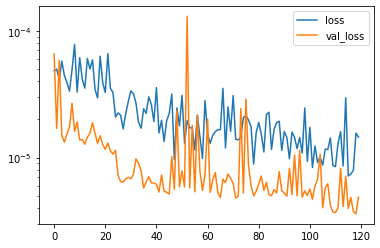

1866/1866 [==============================] - 1633s 875ms/step - loss: 1.4477e-05 - mean_squared_error: 1.4477e-05 - val_loss: 4.8660e-06 - val_mean_squared_error: 4.8660e-06
Wall time: 2d 2h 22min 8s


'history = model.fit(dataset_train, \n                    epochs=EPOCHS, \n                    steps_per_epoch = LEN_DT//BATCH_SIZE_TRAIN,\n                    callbacks=[Early_Stopping, plot_losses], \n                    verbose=1,\n                    validation_data = dataset_val,\n                    validation_steps= (LEN_DT*0.1)//BATCH_SIZE_VAL,\n                    use_multiprocessing = True,\n                    workers = THREADS,\n                    max_queue_size = 1000)'

In [55]:
%%time
#Numero de estadps em el dataset
#LEN_DT = 1921930
LEN_DT = 1910970
EPOCHS = 120
#se usa el repeat para llamar al generador mas de una vez
#steps_per_epoch  = numero de batches de los datos para determinar una epoca terminada 
#Por defecto -> number of samples in your dataset divided by the batch size (LEN_DT//BATCH_SIZE_TRAIN)
#verbose = mostrar el avance del entrenamiento
#validation_steps = numero de batches de datos para validar en cada epoca
#workers?
#max_queue_size?
history = model.fit(dataset_train.repeat(), 
                    epochs=EPOCHS, 
                    steps_per_epoch = LEN_DT//BATCH_SIZE_TRAIN,
                    callbacks=[ plot_losses], 
                    verbose=1,
                    validation_data = dataset_val.repeat(),
                    validation_steps= (LEN_DT*0.1)//BATCH_SIZE_VAL,
                    use_multiprocessing = True,
                    workers = THREADS,
                    max_queue_size = 1000)
"""history = model.fit(dataset_train, 
                    epochs=EPOCHS, 
                    steps_per_epoch = LEN_DT//BATCH_SIZE_TRAIN,
                    callbacks=[Early_Stopping, plot_losses], 
                    verbose=1,
                    validation_data = dataset_val,
                    validation_steps= (LEN_DT*0.1)//BATCH_SIZE_VAL,
                    use_multiprocessing = True,
                    workers = THREADS,
                    max_queue_size = 1000)"""


### Graficar El Error

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


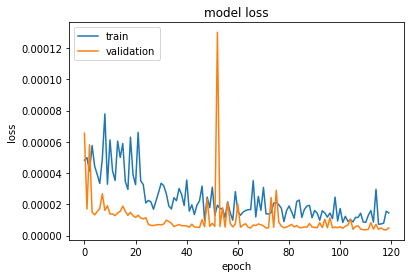

In [56]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Evaluación del Modelo

In [52]:
STEPS_PER_EPOCH = LEN_DT//BATCH_SIZE_TRAIN
loss, mean_sq = model.evaluate(dataset_test 
                               #steps = STEPS_PER_EPOCH//BATCH_SIZE_VAL
                               #workers = THREADS
                              )
K = dict_act_norm['Motor1']["max"] #Ganancia del actuador
print(f'mean_sq: {mean_sq} -> {mean_sq*K} RPM')
print(f'loss: {loss} -> {loss*K} RPM')

    414/Unknown - 158s 383ms/step - loss: 2.8747e-05 - mean_squared_error: 2.8747e-05mean_sq: 2.8747363103320822e-05 -> 0.014373681551660411 RPM
loss: 2.8747367980321396e-05 -> 0.014373683990160698 RPM


#### Se guarda el Modelo

In [57]:
I = 2
model.save(f'Modelos/ControlLSTM_XYZ_{I}.h5')

In [58]:
model = tf.keras.models.load_model(f'Modelos/ControlLSTM_XYZ_{I}.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 4, 110)            59400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                32200     
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 15)                765       
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 64        
Total params: 94,979
Trainable params: 94,979
Non-trainable params: 0
_________________________________________________________________


In [47]:
%%time
x_test = X_test.sample(n=3, random_state=1)
for index, sample in x_test.iterrows():
    print(model.predict([list(sample)])*K['K'])

NameError: name 'X_test' is not defined

In [ ]:
%%time
x_test = [0]*len(states_list)
x_test[0] = 1
x_test[1] = -9.8
x_test[2] = 3
print(model.predict([list(x_test)])*K['K'])

### Guardar los datos de normalizacion de estados en .txt

In [59]:
#Guardar en archivo .txt maximo y minimo de los estados para normalizacion

f_min = open ('min.txt','w')
f_max = open ('max.txt','w')
i=1
for term in states_list_org:
    print(term+" "+str(i))
    print(dict_sts_norm[term]["min"])
    print(dict_sts_norm[term]["max"])
    f_min.write(str(dict_sts_norm[term]["min"]))
    f_min.write("\n")
    f_max.write(str(dict_sts_norm[term]["max"]))
    f_max.write("\n")
    i=i+1
f_min.close()
f_max.close()

X 1
-2.32883215
4.087115765
Y 2
-1.990032196
2.257280588
Z 3
-3.318702459
-0.043110392989999996
Yaw 4
-0.01782442816
0.01982373558
Roll 5
-0.1862723827
0.17205713690000002
Pitch 6
-0.6496306658
0.921472609
Dx 7
-7.666306018999999
4.932723522
Dy 8
-2.1934020519999997
2.015539408
Dz 9
-4.5244045260000005
4.335052013
P 10
-2.1223249440000003
2.084482431
Q 11
-4.033548355
3.39730382
R 12
-0.27050769329999996
0.2673171759
X_r 13
-1.9400000569999998
2.0
Y_r 14
-1.8600000140000001
2.257280588
Z_r 15
-2.774622917
0.49000000950000006
Yaw_r 16
0
0
Pitch_r 17
0
0
Roll_r 18
0
0
Dx_r 19
-161.86373899999998
170.7974243
Dy_r 20
-100.0
100.3757477
Dz_r 21
-346.043457
380.7929382
Acceleracion X 22
-110.5740051
96.57637787
Acceleracion Y 23
-32.13386154
33.82480621
Acceleracion Z 24
-86.47660828
32.25331116


### Guardar los datos de desnormalizacion de salidas

In [60]:
f_act = open ('norm_act.txt','w')

for term in rpm_list:
    print(term)
    print(dict_act_norm[term]["min"])
    print(dict_act_norm[term]["max"])
    f_act.write(str(dict_act_norm[term]["min"]))
    f_act.write("\n")
    f_act.write(str(dict_act_norm[term]["max"]))
    f_act.write("\n")
f_act.close()

Motor1
10.0
500.0
Motor2
-500.0
-10.0
Motor3
10.0
500.0
Motor4
-500.0
-10.0


In [61]:
labels = []
samples = []
batchcount = 0
with open("train.csv", 'r') as csvfile:
            data = csv.reader(csvfile, delimiter=',')
            for index, row in enumerate(data):
                if index<1:
                    print(len(row))
                    continue
                
                #añade a inputs cada columna en la fila
                #.reshape((1,4,23))
                
                samples.append([float(i) for i in row])
                #salidas
                labels.append(samples[batchcount][22*(ORDER+1):])
                #entradas
                samples[batchcount]=np.array(samples[batchcount][:22*(ORDER+1)]).reshape((4,22))
                #print(np.shape(inputs[batchcount]))
                #samples[batchcount]=np.array(samples[batchcount]).reshape((4,22))
                batchcount += 1
                if index>1:
                    break

100


In [36]:
dataset_train

()

In [122]:
labels

[[0.4961280241844298,
  0.502727124446663,
  0.49375391864620877,
  0.5238789598907266],
 [0.5010610390402694,
  0.49976941495293614,
  0.4968764034196375,
  0.5185568259044154]]